# CMU auto-graded notebook

Before you turn these assignments in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

#CMU Machine Learning with Large Datasets

## Homework 1 - Part 2: Entity Resolution

In [4]:
# Who did you collaborate with on this assignment? 
# if no one, collaborators should contain an empty string,
# else list your collaborators below

# collaborators = [""]
# YOUR CODE HERE
# raise NotImplementedError()

collaborators = [""]

In [5]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")

In [6]:
# # YOU CAN MOST LIKELY IGNORE THIS CELL. This is only of use for running this notebook locally.

# # THIS CELL DOES NOT NEED TO BE RUN ON DATABRICKS. 
# # Note that Databricks already creates a SparkContext for you, so this cell can be skipped.
# import findspark
# findspark.init()
# import pyspark
# from pyspark.sql import SQLContext
# sc = pyspark.SparkContext(appName="hw")
# sqlContext = SQLContext(sc)

# print("spark context started")

# **2. Text Analysis and Entity Resolution**
Entity resolution is a common, yet difficult problem in data cleaning and integration. This lab will demonstrate how we can use Apache Spark to apply powerful and scalable text analysis techniques and perform entity resolution across two datasets of commercial products.

Entity Resolution, or "[Record linkage][wiki]" is the term used by statisticians, epidemiologists, and historians, among others, to describe the process of joining records from one data source with another that describe the same entity. Our terms with the same meaning include, "entity disambiguation/linking", "duplicate detection", "deduplication", "record matching", "(reference) reconciliation", "object identification", "data/information integration", and "conflation".

Entity Resolution (ER) refers to the task of finding records in a dataset that refer to the same entity across different data sources (e.g., data files, books, websites, databases). ER is necessary when joining datasets based on entities that may or may not share a common identifier (e.g., database key, URI, National identification number), as may be the case due to differences in record shape, storage location, and/or curator style or preference. A dataset that has undergone ER may be referred to as being cross-linked.
[wiki]: https://en.wikipedia.org/wiki/Record_linkage

## Code

This assignment can be completed using basic Python, PySpark transformations and actions, and the plotting library matplotlib. Other libraries are not allowed.

### Files
[Data files](https://github.com/spark-mooc/mooc-setup/tree/master/metric-learning/data/3-amazon-googleproducts) for this assignment are from the [metric-learning](https://github.com/spark-mooc/mooc-setup/tree/master/metric-learning) project and can be found at:
`dbfs:/FileStore/tables/lab1/`

The directory contains the following files:
* **Google.csv**, the Google Products dataset, named as targets.csv in the repository
* **Amazon.csv**, the Amazon dataset, named as sources.csv in the repository
* **Google_small.csv**, 200 records sampled from the Google data, subset of targets.csv
* **Amazon_small.csv**, 200 records sampled from the Amazon data, subset of sources.csv
* **Amazon_Google_perfectMapping.csv**, the "gold standard" mapping, named as mapping.csv in the repository
* **stopwords.txt**, a list of common English words

Besides the complete data files, there are "sample" data files for each dataset - we will use these for **Part 1**. In addition, there is a "gold standard" file that contains all of the true mappings between entities in the two datasets. Every row in the gold standard file has a pair of record IDs (one Google, one Amazon) that belong to two records that describe the same thing in the real world. We will use the gold standard to evaluate our algorithms.

## Part 0: Preliminaries
We read in each of the files and create an RDD consisting of lines.
For each of the data files ("Google.csv", "Amazon.csv", and the samples), we want to parse the IDs out of each record. The IDs are the first column of the file (they are URLs for Google, and alphanumeric strings for Amazon). Omitting the headers, we load these data files into pair RDDs where the *mapping ID* is the key, and the value is a string consisting of the name/title, description, and manufacturer from the record.

The file format of an Amazon line is:

```
"id","title","description","manufacturer","price"
```

The file format of a Google line is:

```
"id","name","description","manufacturer","price"
```

In [11]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

def removeQuotes(s):
    """ Remove quotation " marks from an input string
    Args:
        s (str): input string that might have the quote "" characters
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


def parseDatafileLine(datafileLine):
    """ Parse a line of the data file using the specified regular expression pattern
    Args:
        datafileLine (str): input string that is a line from the data file
    Returns:
        tuple: a tuple including the parsed results using the given regular expression and without the quote characters
    """
    match = re.search(DATAFILE_PATTERN, datafileLine.decode('utf-8'))
    if match is None:
        print('Invalid datafile line: %s' % datafileLine)
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print('Header datafile line: %s' % datafileLine)
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

Run the following cell to load the data files.

In [13]:
import sys
import os
from pyspark import SparkFiles


GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'


def parseData(filename, path):
    """ Parse a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed lines
    """
    sc.addFile(filename)
    return (sc
            .textFile("file://" + SparkFiles.get(path), 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    """ Load a data file
    Args:
        path (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed valid lines
    """

    url = "https://raw.githubusercontent.com/10605/data/master/hw1/" + path
    raw = parseData(url, path).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print('%s - Invalid datafile line: %s' % (path, line))
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print('%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count()))
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

Google_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
Amazon_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines

Let's examine the lines that were just loaded in the two subset (small) files - one from Google and one from Amazon

In [15]:
for line in googleSmall.take(3):
    print('google: %s: %s\n' % (line[0], line[1]))

for line in amazonSmall.take(3):
    print('amazon: %s: %s\n' % (line[0], line[1]))

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom) "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup v11.1 win 30u for laptops and desktops" "computer associates"

amazon: b00004tkvy: noah's ark activity center (jewel case ages 3-8) "victory multimedia"

## Part 1: ER as Text Similarity - Bags of Words

A simple approach to entity resolution is to treat all records as strings and compute their similarity with a string distance function. In this part, we will build some components for performing bag-of-words text-analysis, and then use them to compute record similarity.
[Bag-of-words][bag-of-words] is a conceptually simple yet powerful approach to text analysis.

The idea is to treat strings, a.k.a. **documents**, as *unordered collections* of words, or **tokens**, i.e., as bags of words.
> **Note on terminology**: a "token" is the result of parsing the document down to the elements we consider "atomic" for the task at hand.  Tokens can be things like words, numbers, acronyms, or other exotica like word-roots or fixed-length character strings.
> Bag of words techniques all apply to any sort of token, so when we say "bag-of-words" we really mean "bag-of-tokens," strictly speaking.
Tokens become the atomic unit of text comparison. If we want to compare two documents, we count how many tokens they share in common. If we want to search for documents with keyword queries (this is what Google does), then we turn the keywords into tokens and find documents that contain them. The power of this approach is that it makes string comparisons insensitive to small differences that probably do not affect meaning much, for example, punctuation and word order.
[bag-of-words]: https://en.wikipedia.org/wiki/Bag-of-words_model

### (1a) Tokenize a String
Implement the function `simpleTokenize(string)` that takes a string and returns a list of non-empty tokens in the string. `simpleTokenize` should split strings using the provided regular expression. Since we want to make token-matching case insensitive, make sure all tokens are turned lower-case. Give an interpretation, in natural language, of what the regular expression, `split_regex`, matches.
If you need help with Regular Expressions, try the site [regex101](https://regex101.com/) where you can interactively explore the results of applying different regular expressions to strings.

*Note that `\W` includes the "_" character*.

You should use [re.split()](https://docs.python.org/2/library/re.html#re.split) to perform the string split. Also:

* make sure you remove any empty tokens
* make sure you convert the string to lower case.

In [18]:
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # return <FILL IN>
    s = re.split(split_regex, string.lower())
    return [i for i in s if i != '']
    
    # YOUR CODE HERE
    raise NotImplementedError()

print(simpleTokenize(quickbrownfox)) # Should give ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [19]:
from nose.tools import assert_equal, assert_true

"""Check that the function turns all characters into lower-case, and returns the tokens in the string """
assert_equal(simpleTokenize(quickbrownfox), ['a','quick','brown','fox','jumps','over','the','lazy','dog'])
"""Check that the function removes non-empty tokens in the string """
assert_equal(simpleTokenize(' '), [])

### (1b) Removing stopwords
*[Stopwords][stopwords]* are common (English) words that do not contribute much to the content or meaning of a document (e.g., "the", "a", "is", "to", etc.). Stopwords add noise to bag-of-words comparisons, so they are usually excluded.
Using the included file "stopwords.txt", implement `tokenize`, an improved tokenizer that does not emit stopwords.
[stopwords]: https://en.wikipedia.org/wiki/Stop_words

**Hint 1**:

In Python, you can test membership in a set as follows:

```
my_set = set(['a', 'b', 'c'])
'a' in my_set     # returns True
'd' in my_set     # returns False
'a' not in my_set # returns False
```

**Hint 2**:

Within `tokenize()`, first tokenize the string using `simpleTokenize()`. Then, remove stopwords. To remove stop words, consider using a loop, a Python [list comprehension](https://docs.python.org/2/tutorial/datastructures.html#list-comprehensions), or the built-in Python [filter()](https://docs.python.org/2/library/functions.html?highlight=filter#filter) function.

In [21]:
stopfile = "https://raw.githubusercontent.com/10605/data/master/hw1/stopwords.txt"
sc.addFile(stopfile)
stopwords = set(sc.textFile("file://" + SparkFiles.get("stopwords.txt")).collect())
print('These are the stopwords: %s' % stopwords)


def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # return <FILL IN>
    string = simpleTokenize(string)
    return [i for i in string if i not in stopwords]
  
    # YOUR CODE HERE
    raise NotImplementedError()

# print(quickbrownfox)
print('Tokenize: ')
print(tokenize(quickbrownfox)) # Should give ['quick', 'brown', ... ]

These are the stopwords: {'out', 'we', 'was', 'how', 'myself', 'for', 'they', 'about', 'then', 'both', 'so', 'don', 'as', 'any', 'after', 'you', 'why', 'been', 'where', 'by', 'yourself', 'a', 'did', 'their', 'doing', 'be', 'further', 'ours', 'now', 'am', 'her', 'yourselves', 'that', 'what', 'my', 'to', 'not', 'own', 'there', 'this', 'each', 'all', 'more', 'me', 'which', 'himself', 'nor', 'other', 'who', 'same', 'at', 'such', 't', 'up', 'than', 'can', 'too', 'these', 'while', 'before', 'ourselves', 'he', 'i', 'our', 'its', 'but', 'with', 'because', 'those', 'the', 'it', 'hers', 'just', 'over', 'between', 'had', 'does', 'have', 'and', 'some', 'or', 'only', 'when', 'below', 'in', 'if', 'theirs', 'again', 'his', 'whom', 'above', 'should', 'itself', 'themselves', 'until', 'are', 'she', 'will', 'from', 'into', 'no', 'your', 'few', 'herself', 'of', 'has', 'down', 'were', 'once', 'having', 'them', 'under', 'him', 'do', 'on', 'an', 'yours', 'being', 'off', 'very', 'through', 'most', 'against', 'here', 'is', 's', 'during'}
Tokenize: 
['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']

In [22]:
"""Check that 'why', 'a', 'the' are all stopping words"""
assert_equal(tokenize("Why a the?"), [])
"""Check that the word character \W includes _"""
assert_equal(tokenize("Being at the_?"), ['the_'])
"""Check that the function first tokenizes the string, then removes stopping words"""
assert_equal(tokenize(quickbrownfox), ['quick','brown','fox','jumps','lazy','dog'])

### (1c) Tokenizing the small datasets
Now let's tokenize the two *small* datasets. For each ID in a dataset, `tokenize` the values, and then count the total number of tokens.

The resulting RDDs, `amazonRecToToken` and `googleRecToToken` should be collections of `(recordID, [token_list])` pairs. For instance, here's a record that should be found in the resulting `amazonRecToToken` RDD:

```
('b00004tkvy', ['noah', 'ark', 'activity', 'center', 'jewel', 'case', 'ages', '3', '8', 'victory', 'multimedia'])
```

How many tokens, total, are there in the two datasets?

In [24]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# amazonRecToToken = amazonSmall.<FILL IN>
# googleRecToToken = googleSmall.<FILL IN>

# YOUR CODE HERE
# raise NotImplementedError()

amazonRecToToken = amazonSmall.map(lambda x: (x[0], tokenize(x[1])) )
googleRecToToken = googleSmall.map(lambda x: (x[0], tokenize(x[1])) )

def countTokens(vendorRDD):
    """ Count and return the number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # recordCount = vendorRDD.<FILL IN>
    # recordSum = recordCount.<FILL IN>
    # return recordSum
    recordCount = vendorRDD.map(lambda x: len(x[1]))
    recordSum =  recordCount.sum()
    return recordSum

    # YOUR CODE HERE
    raise NotImplementedError()

totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken)
print('There are %s tokens in the combined datasets' % totalTokens)

There are 22520 tokens in the combined datasets

In [25]:
amazonRecToToken.take(20)

Out[273]: [('b000jz4hqo',
 ['clickart',
 '950',
 '000',
 'premier',
 'image',
 'pack',
 'dvd',
 'rom',
 'broderbund']),
 ('b0006zf55o',
 ['ca',
 'international',
 'arcserve',
 'lap',
 'desktop',
 'oem',
 '30pk',
 'oem',
 'arcserve',
 'backup',
 'v11',
 '1',
 'win',
 '30u',
 'laptops',
 'desktops',
 'computer',
 'associates']),
 ('b00004tkvy',
 ['noah',
 'ark',
 'activity',
 'center',
 'jewel',
 'case',
 'ages',
 '3',
 '8',
 'victory',
 'multimedia']),
 ('b000g80lqo',
 ['peachtree',
 'sage',
 'premium',
 'accounting',
 'nonprofits',
 '2007',
 'peachtree',
 'premium',
 'accounting',
 'nonprofits',
 '2007',
 'affordable',
 'easy',
 'use',
 'accounting',
 'solution',
 'provides',
 'donor',
 'grantor',
 'management',
 're',
 'like',
 'nonprofit',
 'organizations',
 're',
 'constantly',
 'striving',
 'maximize',
 'every',
 'dollar',
 'annual',
 'operating',
 'budget',
 'financial',
 'reporting',
 'programs',
 'funds',
 'advanced',
 'operational',
 'reporting',
 'rock',
 'solid',
 'core',
 'accounting',
 'features',
 'made',
 'peachtree',
 'choice',
 'hundreds',
 'thousands',
 'small',
 'businesses',
 'result',
 'accounting',
 'solution',
 'tailor',
 'made',
 'challenges',
 'operating',
 'nonprofit',
 'organization',
 'keep',
 'audit',
 'trail',
 'record',
 'report',
 'changes',
 'made',
 'transactions',
 'improve',
 'data',
 'integrity',
 'prior',
 'period',
 'locking',
 'archive',
 'organization',
 'data',
 'snap',
 'shots',
 'data',
 'closed',
 'year',
 'set',
 'individual',
 'user',
 'profiles',
 'password',
 'protection',
 'peachtree',
 'restore',
 'wizard',
 'restores',
 'backed',
 'data',
 'files',
 'plus',
 'web',
 'transactions',
 'customized',
 'forms',
 'includes',
 'standard',
 'accounting',
 'features',
 'general',
 'ledger',
 'accounts',
 'receivable',
 'accounts',
 'payable',
 'payroll',
 'solutions',
 'time',
 'billing',
 'job',
 'costing',
 'fixed',
 'assets',
 'analysis',
 'reporting',
 'customization',
 'easily',
 'convert',
 'quickbooks',
 'sage',
 'software']),
 ('b0006se5bq',
 ['singing',
 'coach',
 'unlimited',
 'singing',
 'coach',
 'unlimited',
 'electronic',
 'learning',
 'products',
 'win',
 'nt',
 '2000',
 'xp',
 'carry',
 'tune',
 'technologies']),
 ('b000ehpzv8',
 ['emc',
 'retrospect',
 '7',
 '5',
 'disk',
 'disk',
 'windows',
 'emc',
 'retrospect',
 '7',
 '5',
 'disk',
 'diskcromwindows',
 'dantz']),
 ('b00021xhzw',
 ['adobe',
 'effects',
 'professional',
 '6',
 '5',
 'upgrade',
 'standard',
 'professional',
 'upgrade',
 'installation',
 'effects',
 'standard',
 'new',
 'disk',
 'caching',
 'tools',
 'speed',
 'interactive',
 'work',
 'save',
 'combination',
 'animation',
 'parameters',
 'presets',
 'create',
 'transformations',
 'masks',
 'expressions',
 'effects',
 'text',
 'tighter',
 'integration',
 'adobe',
 'tools',
 'import',
 'photoshop',
 'cs',
 'illustrator',
 'cs',
 'files',
 'preserved',
 'layers',
 'attributes',
 'output',
 'firewire',
 'easier',
 'previewing',
 'ntsc',
 'pal',
 'video',
 'monitors',
 'adobe']),
 ('b000gzwjgc',
 ['acad',
 'upgrade',
 'dragon',
 'naturallyspeaking',
 'pro',
 'solution',
 '9',
 '0',
 'a289a',
 'fd7',
 '9',
 '0',
 'marketing',
 'information',
 'dragon',
 'naturallyspeakingprofessional',
 '9',
 'saveyou',
 'organizationmoney',
 'itempowers',
 'anyone',
 'tocreate',
 'documents',
 'overthree',
 'times',
 'faster',
 'thantyping',
 'also',
 'protectsagainst',
 'repetitive',
 'stressinjuries',
 'result',
 'lostproductivity',
 'higher',
 'workers',
 'compensationpremiums',
 'higher',
 'temporary',
 'labor',
 'costs',
 'accuracy',
 'performance',
 'ease',
 'use',
 'indragon',
 'naturallyspeaking',
 'professional',
 '9make',
 'ideal',
 'solution',
 'busy',
 'corporateprofessionals',
 'employees',
 'canuse',
 'dragon',
 'naturallyspeaking',
 'professionalto',
 'create',
 'documents',
 'email',
 'messages',
 'write',
 'reports',
 'complete',
 'forms',
 'voice',
 'product',
 'information',
 'software',
 'sub',
 'type',
 'voice',
 'recognition',
 'software',
 'name',
 'd

In [26]:
"""Check that the total number of tokens in two datasets are 22520"""
assert_equal(totalTokens, 22520)

### (1d) Amazon record with the most tokens
Which Amazon record has the biggest number of tokens?
In other words, you want to sort the records and get the one with the largest count of tokens.

**Hint**: The RDD [takeOrdered()](http://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.RDD.takeOrdered) transformation may be of some help here.

In [28]:
def findBiggestRecord(vendorRDD):
    """ Find and return the record with the largest number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokens)): input Pair Tuple of record ID and tokens
    Returns:
        list: a list of 1 Pair Tuple of record ID and tokens
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # return <FILL IN>
    return vendorRDD.sortBy(lambda x: -len(x[1])).collect()
    
    # YOUR CODE HERE
    raise NotImplementedError()

biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print('The Amazon record with ID "%s" has the most tokens (%s)' % (biggestRecordAmazon[0][0],
                                                                   len(biggestRecordAmazon[0][1])))

The Amazon record with ID "b000o24l3q" has the most tokens (1547)

In [29]:
"""Check that some record has the largest number of tokens 1547"""
assert_equal(len(biggestRecordAmazon[0][1]), 1547)

## Part 2: ER as Text Similarity - Weighted Bag-of-Words using TF-IDF
Bag-of-words comparisons are not very good when all tokens are treated the same: some tokens are more important than others. Weights give us a way to specify which tokens to favor. With weights, when we compare documents, instead of counting common tokens, we sum up the weights of common tokens. A good heuristic for assigning weights is called "Term-Frequency/Inverse-Document-Frequency," or [TF-IDF][tfidf] for short.

### TF

TF rewards tokens that appear many times in the same document. It is computed as the frequency of a token in a document, that is, if document *d* contains 100 tokens and token *t* appears in *d* 5 times, then the TF weight of *t* in *d* is *5/100 = 1/20*. The intuition for TF is that if a word occurs often in a document, then it is more important to the meaning of the document.

### IDF

IDF rewards tokens that are rare overall in a dataset. The intuition is that it is more significant if two documents share a rare word than a common one. IDF weight for a token, *t*, in a set of documents, *U*, is computed as follows:
* Let *N* be the total number of documents in *U*
* Find *n(t)*, the number of documents in *U* that contain *t*
* Then *IDF(t) = N/n(t)*.

Note that *n(t)/N* is the frequency of *t* in *U*, and *N/n(t)* is the inverse frequency.

> **Note on terminology**: Sometimes token weights depend on the document the token belongs to, that is, the same token may have a different weight when it's found in different documents.  We call these weights *local* weights.  TF is an example of a local weight, because it depends on the length of the source.  On the other hand, some token weights only depend on the token, and are the same everywhere that token is found.  We call these weights *global*, and IDF is one such weight.

### TF-IDF

Finally, to bring it all together, the total TF-IDF weight for a token in a document is the product of its TF and IDF weights.
[tfidf]: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### (2a) Implement a TF function

Implement `tf(tokens)` that takes a list of tokens and returns a Python [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) mapping tokens to TF weights.

The steps your function should perform are:
* Create an empty Python dictionary
* For each of the tokens in the input `tokens` list, count 1 for each occurrence and add the token to the dictionary
* For each of the tokens in the dictionary, divide the token's count by the total number of tokens in the input `tokens` list

In [32]:
print(tokenize(quickbrownfox))

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']

In [33]:
def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # <FILL IN>

    # YOUR CODE HERE
    num = float(len(tokens))
    return {x: tokens.count(x)/num for x in set(tokens)}
#     return dict( (x, tokens.count(x)/num) for x in set(tokens) )


print(tf(tokenize(quickbrownfox))) # Should give { 'quick': 0.1666 ... }

{'jumps': 0.16666666666666666, 'lazy': 0.16666666666666666, 'brown': 0.16666666666666666, 'quick': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666}

In [34]:
"""Check for the TF score of each word in the list of tokens extracted from the string"""
tf_test = tf(tokenize(quickbrownfox))
assert_equal(tf_test, {'brown': 0.16666666666666666, 'lazy': 0.16666666666666666,
                       'jumps': 0.16666666666666666, 'fox': 0.16666666666666666,
                       'dog': 0.16666666666666666, 'quick': 0.16666666666666666})
"""Check for the TF score of each word in the list of tokens extracted from the string"""
tf_test2 = tf(tokenize('one_ one_ two!'))
assert_equal(tf_test2,  {'one_': 0.6666666666666666, 'two': 0.3333333333333333})


### (2b) Create a corpus
Create a pair RDD called `corpusRDD`, consisting of a combination of the two small datasets, `amazonRecToToken` and `googleRecToToken`. Each element of the `corpusRDD` should be a pair consisting of a key from one of the small datasets (ID or URL) and the value is the associated value for that key from the small datasets.

In [36]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# corpusRDD = <FILL IN>

corpusRDD = amazonRecToToken.union(googleRecToToken)

# YOUR CODE HERE
# raise NotImplementedError()

In [37]:
for i in corpusRDD.take(50):
    print(i)

('b000jz4hqo', ['clickart', '950', '000', 'premier', 'image', 'pack', 'dvd', 'rom', 'broderbund'])
('b0006zf55o', ['ca', 'international', 'arcserve', 'lap', 'desktop', 'oem', '30pk', 'oem', 'arcserve', 'backup', 'v11', '1', 'win', '30u', 'laptops', 'desktops', 'computer', 'associates'])
('b00004tkvy', ['noah', 'ark', 'activity', 'center', 'jewel', 'case', 'ages', '3', '8', 'victory', 'multimedia'])
('b000g80lqo', ['peachtree', 'sage', 'premium', 'accounting', 'nonprofits', '2007', 'peachtree', 'premium', 'accounting', 'nonprofits', '2007', 'affordable', 'easy', 'use', 'accounting', 'solution', 'provides', 'donor', 'grantor', 'management', 're', 'like', 'nonprofit', 'organizations', 're', 'constantly', 'striving', 'maximize', 'every', 'dollar', 'annual', 'operating', 'budget', 'financial', 'reporting', 'programs', 'funds', 'advanced', 'operational', 'reporting', 'rock', 'solid', 'core', 'accounting', 'features', 'made', 'peachtree', 'choice', 'hundreds', 'thousands', 'small', 'businesses', 'result', 'accounting', 'solution', 'tailor', 'made', 'challenges', 'operating', 'nonprofit', 'organization', 'keep', 'audit', 'trail', 'record', 'report', 'changes', 'made', 'transactions', 'improve', 'data', 'integrity', 'prior', 'period', 'locking', 'archive', 'organization', 'data', 'snap', 'shots', 'data', 'closed', 'year', 'set', 'individual', 'user', 'profiles', 'password', 'protection', 'peachtree', 'restore', 'wizard', 'restores', 'backed', 'data', 'files', 'plus', 'web', 'transactions', 'customized', 'forms', 'includes', 'standard', 'accounting', 'features', 'general', 'ledger', 'accounts', 'receivable', 'accounts', 'payable', 'payroll', 'solutions', 'time', 'billing', 'job', 'costing', 'fixed', 'assets', 'analysis', 'reporting', 'customization', 'easily', 'convert', 'quickbooks', 'sage', 'software'])
('b0006se5bq', ['singing', 'coach', 'unlimited', 'singing', 'coach', 'unlimited', 'electronic', 'learning', 'products', 'win', 'nt', '2000', 'xp', 'carry', 'tune', 'technologies'])
('b000ehpzv8', ['emc', 'retrospect', '7', '5', 'disk', 'disk', 'windows', 'emc', 'retrospect', '7', '5', 'disk', 'diskcromwindows', 'dantz'])
('b00021xhzw', ['adobe', 'effects', 'professional', '6', '5', 'upgrade', 'standard', 'professional', 'upgrade', 'installation', 'effects', 'standard', 'new', 'disk', 'caching', 'tools', 'speed', 'interactive', 'work', 'save', 'combination', 'animation', 'parameters', 'presets', 'create', 'transformations', 'masks', 'expressions', 'effects', 'text', 'tighter', 'integration', 'adobe', 'tools', 'import', 'photoshop', 'cs', 'illustrator', 'cs', 'files', 'preserved', 'layers', 'attributes', 'output', 'firewire', 'easier', 'previewing', 'ntsc', 'pal', 'video', 'monitors', 'adobe'])
('b000gzwjgc', ['acad', 'upgrade', 'dragon', 'naturallyspeaking', 'pro', 'solution', '9', '0', 'a289a', 'fd7', '9', '0', 'marketing', 'information', 'dragon', 'naturallyspeakingprofessional', '9', 'saveyou', 'organizationmoney', 'itempowers', 'anyone', 'tocreate', 'documents', 'overthree', 'times', 'faster', 'thantyping', 'also', 'protectsagainst', 'repetitive', 'stressinjuries', 'result', 'lostproductivity', 'higher', 'workers', 'compensationpremiums', 'higher', 'temporary', 'labor', 'costs', 'accuracy', 'performance', 'ease', 'use', 'indragon', 'naturallyspeaking', 'professional', '9make', 'ideal', 'solution', 'busy', 'corporateprofessionals', 'employees', 'canuse', 'dragon', 'naturallyspeaking', 'professionalto', 'create', 'documents', 'email', 'messages', 'write', 'reports', 'complete', 'forms', 'voice', 'product', 'information', 'software', 'sub', 'type', 'voice', 'recognition', 'software', 'name', 'dragon', 'naturallyspeaking', 'v', '9', '0', 'professional', 'upgrade', 'features', 'benefits', 'accurate', 'ever', 'faster', 'safer', 'typing', 'section', '508', 'certified', 'easy', 'use', 'special', 'user', 'training', 'required', 'support', 'citrix', 'thin', 'client', 'environments', 'enterprise', 'ready', 'ease', 'administration', 'mobility',

In [38]:
"""Check that there are 400 records in the two small datasets in total"""
assert_equal(corpusRDD.count(), 400)
"""Check that the third smallest token from the token list associated with Record b000jz4hqo is clickart"""
_data = corpusRDD.filter(lambda t: t[0] == 'b000jz4hqo').collect()
_words = sorted(_data[0][1])
assert_equal(_words[3], 'clickart')

### (2c) Implement an IDFs function
Implement `idfs` that assigns an IDF weight to every unique token in an RDD called `corpus`. The function should return a pair RDD where the `key` is the unique token and value is the IDF weight for the token.

Recall that the IDF weight for a token, *t*, in a set of documents, *U*, is computed as follows:
* Let *N* be the total number of documents in *U*.
* Find *n(t)*, the number of documents in *U* that contain *t*.
* Then *IDF(t) = N/n(t)*.

The steps your function should perform are:
* Calculate *N*. Think about how you can calculate *N* from the input RDD.
* Create an RDD (*not a pair RDD*) containing the unique tokens from each document in the input `corpus`. For each document, you should only include a token once, *even if it appears multiple times in that document.*
* For each of the unique tokens, count how many documents it appears in and then compute the IDF for that token: *N/n(t)*

Use your `idfs` to compute the IDF weights for all tokens in `corpusRDD` (the combined small datasets).
How many unique tokens are there?

In [40]:
uniqueTokens = corpusRDD.flatMap(lambda x: set(x[1]))
print(uniqueTokens.take(100))

['pack', 'clickart', '950', 'premier', 'broderbund', '000', 'rom', 'dvd', 'image', 'v11', 'associates', 'ca', 'international', 'arcserve', '30pk', 'desktop', 'laptops', 'lap', 'desktops', '1', 'win', 'oem', 'backup', 'computer', '30u', 'center', '3', 'noah', 'case', 'victory', '8', 'jewel', 'activity', 'ages', 'multimedia', 'ark', 'improve', 'restore', 'receivable', 'affordable', 're', 'costing', 'tailor', 'closed', 'convert', 'fixed', 'rock', 'plus', 'easily', 'features', 'sage', 'wizard', 'made', 'management', 'job', 'peachtree', 'includes', 'organization', 'solid', 'result', 'accounting', 'backed', 'integrity', 'every', 'general', 'financial', 'report', 'constantly', 'customized', '2007', 'premium', 'restores', 'nonprofits', 'files', 'use', 'user', 'challenges', 'time', 'solution', 'small', 'set', 'standard', 'prior', 'reporting', 'payroll', 'analysis', 'changes', 'operating', 'ledger', 'keep', 'record', 'hundreds', 'programs', 'shots', 'funds', 'password', 'core', 'dollar', 'solutions', 'customization']

In [41]:
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (token, IDF value)
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # uniqueTokens = corpus.<FILL IN>
    # tokenCountPairTuple = uniqueTokens.<FILL IN>
    # tokenSumPairTuple = tokenCountPairTuple.<FILL IN>
    # N = <FILL IN>
    # return (tokenSumPairTuple.<FILL IN>)
    
    uniqueTokens = corpus.flatMap(lambda x: set(x[1]))
    tokenCountPairTuple = uniqueTokens.map(lambda x: (x, 1))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda x,y: x+y)
    N = float(corpus.count())
    return (tokenSumPairTuple.map(  lambda x: (x[0], N/x[1]))  )
  
    # YOUR CODE HERE
    raise NotImplementedError()

idfsSmall = idfs(corpusRDD)
uniqueTokenCount = idfsSmall.count()

print('There are %s unique tokens in the small datasets.' % uniqueTokenCount)

There are 4772 unique tokens in the small datasets.

In [42]:
"""Check that the number of unique tokens in the combined small datasets is 4772"""
assert_equal(uniqueTokenCount, 4772)


### (2d) Tokens with the smallest IDF
Print out the 11 tokens with the smallest IDF in the combined small dataset.

In [44]:
# *answer*: The 10 smallest IDFs are for: (1) software, (2 tie) new, (2 tie) features, (4) use, (5) complete, (6) easy, (7 tie) cd, (7 tie) system, (7 tie) create, (10 tie) windows, (10 tie) 1

# These terms not useful for entity resolution because they are generic terms for marketing, prices, and product categories.

# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# smallIDFTokens = <FILL_IN>

# YOUR CODE HERE
# raise NotImplementedError()

smallIDFTokens = idfsSmall.takeOrdered(11, lambda x: x[1])

print(smallIDFTokens)

[('software', 4.25531914893617), ('features', 6.896551724137931), ('new', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('cd', 8.333333333333334), ('create', 8.333333333333334), ('system', 8.333333333333334), ('windows', 8.51063829787234), ('1', 8.51063829787234)]

In [45]:
_data = sorted(smallIDFTokens)
"""Check that the first token (among the 11 tokens with the smallest idf) is '1' (in string order)"""
assert_equal(_data[0][0], '1')
"""Check that the third token (among the 11 tokens with the smallest idf) is 'complete' (in string order)"""
assert_equal(_data[2][0], 'complete')
_expected = ['1', 'cd', 'complete', 'create', 'easy', 'features', 'new', 'software', 'system', 'use', 'windows']
_got = [t[0] for t in _data]
"""Check that the 11 tokens with the smallest idf are sorted by the string order"""
assert_equal(_got, _expected)

### (2e) IDF Histogram
Plot a histogram of IDF values.  Be sure to use appropriate scaling and bucketing for the data.

First plot the histogram using [matplotlib](https://matplotlib.org/3.1.1/gallery/statistics/hist.html)

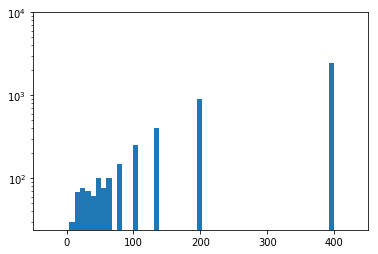

In [47]:
import matplotlib.pyplot as plt

# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# small_idf_values = <FILL_IN>
# fig = <FILL_IN>
# plt.<FILL_IN>

# YOUR CODE HERE
# raise NotImplementedError()

small_idf_values =idfsSmall.map(lambda x: x[1]).collect()
fig = plt.figure()
plt.hist(small_idf_values, bins = 50, log=True)
plt.axis((-50, 450, 0, 1e4))
display(fig)

Next, plot the histogram using the Databricks `display()` function. After the cell runs, click on Plot Options and select Histogram.

In [49]:
from pyspark.sql import Row

# Create a DataFrame and visualize using display()
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# idfsToCountRow = idfsSmall.<FILL_IN>
# idfsToCountDF = sqlContext.<FILL_IN>

# YOUR CODE HERE
# raise NotImplementedError()


idfsToCountRow = idfsSmall.map(lambda x: Row(Tokens=x[0], IDF=x[1]) )
idfsToCountDF = sqlContext.createDataFrame(idfsToCountRow)
display(idfsToCountDF)

IDF,Tokens
400.0,950
16.666666666666668,rom
16.0,dvd
400.0,v11
57.142857142857146,ca
200.0,lap
133.33333333333334,result
80.0,backed
200.0,constantly
14.285714285714286,files


### (2f) Implement a TF-IDF function
Use your `tf` function to implement a `tfidf(tokens, idfs)` function that takes a list of tokens from a document and a Python dictionary of IDF weights and returns a Python dictionary mapping individual tokens to total TF-IDF weights.

The steps your function should perform are:
* Calculate the token frequencies (TF) for `tokens`
* Create a Python dictionary where each token maps to the token's frequency times the token's IDF weight

Use your `tfidf` function to compute the weights of Amazon product record 'b000hkgj8k'. To do this, we need to extract the record for the token from the tokenized small Amazon dataset and we need to convert the IDFs for the small dataset into a Python dictionary. We can do the first part, by using a `filter()` transformation to extract the matching record and a `collect()` action to return the value to the driver.

For the second part, we use the [`collectAsMap()` action](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) to return the IDFs to the driver as a Python dictionary.

In [51]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # tfs = <FILL IN>
    # tfIdfDict = <FILL IN>
    # return tfIdfDict
    
    tfs = tf(tokens) # tf returns a dictionary
    tfIdfDict = {x: idfs[x]*tfs[x] for x in tokens } 
    return tfIdfDict
    
    # YOUR CODE HERE
    raise NotImplementedError()

recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()

# print(recb000hkgj8k)
# print(idfsSmallWeights)
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights)

recb000jz4hqo = amazonRecToToken.filter(lambda x: x[0] == 'b000jz4hqo').collect()[0][1]
rec_b000jz4hqo_weights = tfidf(recb000jz4hqo, idfsSmallWeights)

print('Amazon record "b000hkgj8k" has tokens and weights:\n%s' % rec_b000hkgj8k_weights)
print('Amazon record "b000jz4hqo" has tokens and weights: \n%s' % rec_b000jz4hqo_weights)

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 33.33333333333333, '2007': 3.5087719298245617, 'courseware': 66.66666666666666, 'customizing': 16.666666666666664, 'interface': 3.0303030303030303, 'autodesk': 8.333333333333332, 'psg': 33.33333333333333}
Amazon record "b000jz4hqo" has tokens and weights: 
{'clickart': 22.22222222222222, '950': 44.44444444444444, '000': 4.444444444444445, 'premier': 11.11111111111111, 'image': 4.040404040404041, 'pack': 3.4188034188034186, 'dvd': 1.7777777777777777, 'rom': 1.8518518518518519, 'broderbund': 22.22222222222222}

In [52]:
"""Check for the TFIDF score vector associated with Record recb000jz4hqo"""
assert_equal(rec_b000hkgj8k_weights, 
                   {'autocad': 33.33333333333333, 'autodesk': 8.333333333333332,
                    'courseware': 66.66666666666666, 'psg': 33.33333333333333,
                    '2007': 3.5087719298245617, 'customizing': 16.666666666666664,
                    'interface': 3.0303030303030303})


## Part 3: ER as Text Similarity - Cosine Similarity
Now we are ready to do text comparisons in a formal way. The metric of string distance we will use is called **[cosine similarity][cosine]**. We will treat each document as a vector in some high dimensional space. Then, to compare two documents we compute the cosine of the angle between their two document vectors. This is *much* easier than it sounds.

The first question to answer is how do we represent documents as vectors? The answer is familiar: bag-of-words! We treat each unique token as a dimension, and treat token weights as magnitudes in their respective token dimensions. For example, suppose we use simple counts as weights, and we want to interpret the string "Hello, world!  Goodbye, world!" as a vector. Then in the "hello" and "goodbye" dimensions the vector has value 1, in the "world" dimension it has value 2, and it is zero in all other dimensions.

The next question is: given two vectors how do we find the cosine of the angle between them? Recall the formula for the dot product of two vectors:
\\[ a \cdot b = \| a \| \| b \| \cos \theta \\]
Here \\( a \cdot b = \sum a_i b_i \\) is the ordinary dot product of two vectors, and \\( \|a\| = \sqrt{ \sum a_i^2 } \\) is the norm of \\( a \\).

We can rearrange terms and solve for the cosine to find it is simply the normalized dot product of the vectors. With our vector model, the dot product and norm computations are simple functions of the bag-of-words document representations, so we now have a formal way to compute similarity:
\\[ similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} \\]

Setting aside the algebra, the geometric interpretation is more intuitive. The angle between two document vectors is small if they share many tokens in common, because they are pointing in roughly the same direction. For that case, the cosine of the angle will be large. Otherwise, if the angle is large (and they have few words in common), the cosine is small. Therefore, cosine similarity scales proportionally with our intuitive sense of similarity.
[cosine]: https://en.wikipedia.org/wiki/Cosine_similarity

### (3a) Implement the components of a `cosineSimilarity` function
Implement the components of a `cosineSimilarity` function.
Use the `tokenize` and `tfidf` functions, and the IDF weights from Part 2 for extracting tokens and assigning them weights.
The steps you should perform are:
* Define a function `dotprod` that takes two Python dictionaries and produces the dot product of them, where the dot product is defined as the sum of the product of values for tokens that appear in *both* dictionaries
* Define a function `norm` that returns the square root of the dot product of a dictionary and itself
* Define a function `cossim` that returns the dot product of two dictionaries divided by the norm of the first dictionary and then by the norm of the second dictionary

In [55]:
import math

def dotprod(a, b):
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # return <FILL IN>
    
    return sum( [a[x]*b[x] for x in a if x in b] )
    # YOUR CODE HERE
    raise NotImplementedError()

def norm(a):
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # return <FILL IN>
    
    return math.sqrt(sum([a[x]*a[x] for x in a]))
    # YOUR CODE HERE
    raise NotImplementedError()

def cossim(a, b):
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # return <FILL IN>
    
    return float( dotprod(a, b)/ (norm(a) * norm(b) ) )
    # YOUR CODE HERE
    raise NotImplementedError()

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
cs = cossim(testVec1, testVec2)
print(dp, nm, cs)

102 6.164414002968976 0.8262970212292282

In [56]:
"""Check that the dot product between testVec1 and testVec2 is 102"""
assert_equal(dp, 102)
"""Check that the L2 norm of testVec1 is around 6.16441400297"""
assert_true(abs(nm - 6.16441400297) < 0.0000001)
"""Check that the cosine similarity between testVec1 and testVec2 is around 0.826297021229"""
assert_true(abs(cs - 0.826297021229) < 0.0000001)

### (3b) Implement a `cosineSimilarity` function
Implement a `cosineSimilarity(string1, string2, idfsDictionary)` function that takes two strings and a dictionary of IDF weights, and computes their cosine similarity in the context of some global IDF weights.

The steps you should perform are:
* Apply your `tfidf` function to the tokenized first and second strings, using the dictionary of IDF weights
* Compute and return your `cossim` function applied to the results of the two `tfidf` functions

In [58]:
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    w1 = tfidf(tokenize(string1), idfsDictionary)
    w2 = tfidf(tokenize(string2), idfsDictionary)
    
    # YOUR CODE HERE
#     raise NotImplementedError()
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)

print(cossimAdobe)

0.05772433821630337

In [59]:
"""Check that the cosine similarity between Adobe Photoshop and Adobe Illustrator is around 0.0577243382163"""
assert_true(abs(cossimAdobe - 0.0577243382163) < 0.0000001)

### (3c) Perform Entity Resolution
Now we can finally do some entity resolution!
For *every* product record in the small Google dataset, use your `cosineSimilarity` function to compute its similarity to every record in the small Amazon dataset.  Then, build a dictionary mapping `(Google URL, Amazon ID)` tuples to similarity scores between 0 and 1.
We'll do this computation two different ways, first we'll do it without a broadcast variable, and then we'll use a broadcast variable

The steps you should perform are:
* Create an RDD that is a combination of the small Google and small Amazon datasets that has as elements all pairs of elements (a, b) where a is in self and b is in other. The result will be an RDD of the form: `[ ((Google URL1, Google String1), (Amazon ID1, Amazon String1)), ((Google URL1, Google String1), (Amazon ID2, Amazon String2)), ((Google URL2, Google String2), (Amazon ID1, Amazon String1)), ... ]`
* Define a worker function that given an element from the combination RDD computes the cosineSimlarity for the two records in the element
* Apply the worker function to every element in the RDD

Now, compute the similarity between Amazon record `b000o24l3q` and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

**Hint**: Use Spark's [cartesian](https://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.RDD.cartesian) method.

In [61]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# crossSmall = (googleSmall
#               .<FILL IN>
#               .cache())

# YOUR CODE HERE
# raise NotImplementedError()
crossSmall = (googleSmall
              .cartesian(amazonSmall)
              .cache())

def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    
    
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # googleURL = <FILL IN>
    # amazonID = <FILL IN>
    # googleValue = <FILL IN>
    # amazonValue = <FILL IN>
    # cs = cosineSimilarity(<FILL IN>, idfsSmallWeights)
    
    # YOUR CODE HERE
#     raise NotImplementedError()

    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)
  
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# similarities = (crossSmall
#                 .<FILL IN>
#                 .cache())

# YOUR CODE HERE
# raise NotImplementedError()
similarities = (crossSmall
                .map(computeSimilarity)
                .cache())

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarityAmazonGoogle)

Requested similarity is 0.00030317194045132.

In [62]:
"""Check that the cosine similarity between the Amazon record and the Google record is around 0.000303171940451"""
assert_true(abs(similarityAmazonGoogle - 0.000303171940451) < 0.0000001)

### (3d) Perform Entity Resolution with Broadcast Variables
The solution in (3c) works well for small datasets, but it requires Spark to (automatically) send the `idfsSmallWeights` variable to all the workers _for each record_. For example, if we only have one worker, and we have 1,000 records, we would be sending `idfSmallWeights` to the same worker 1,000 times. Further, if we didn't `cache()` similarities, then it might have to be recreated if we run `similar()` multiple times. While this approach works fine for small datasets, it becomes a bottleneck for larger datasets.

Instead, we can use a broadcast variable - we define the broadcast variable in the driver and then we can refer to it in each worker. Spark saves the broadcast variable at each worker, so it is only sent once.

The steps you should perform are:
* Define a `computeSimilarityBroadcast` function that given an element from the combination RDD computes the cosine simlarity for the two records in the element. This will be the same as the worker function `computeSimilarity` in (3c) except that it uses a broadcast variable.
* Apply the worker function to every element in the RDD

Again, compute the similarity between Amazon record `b000o24l3q` and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [64]:
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    
    # TODO: Uncomment the template below and replace <FILL IN> with appropriate code
    # googleURL = <FILL IN>
    # amazonID = <FILL IN>
    # googleValue = <FILL IN>
    # amazonValue = <FILL IN>
    # cs = cosineSimilarity(<FILL IN>, idfsSmallBroadcast.value)
    
    # YOUR CODE HERE
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)

# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# similaritiesBroadcast = (crossSmall
#                          .<FILL IN>
#                          .cache())

# YOUR CODE HERE
# raise NotImplementedError()
similaritiesBroadcast = (crossSmall
                         .map(computeSimilarityBroadcast)
                         .cache())

def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarityAmazonGoogleBroadcast)

Requested similarity is 0.00030317194045132.

In [65]:
from pyspark import Broadcast
"""Check that idfsSmallBroadcast is a boradcast variable"""
assert_true(isinstance(idfsSmallBroadcast, Broadcast))
"""Check that the number of weights/tokens is 4772"""
assert_equal(len(idfsSmallBroadcast.value), 4772)
"""Check that the cosine similarity between the Amazon record and the Google record is around 0.000303171940451"""
assert_true(abs(similarityAmazonGoogleBroadcast - 0.000303171940451) < 0.0000001)

### (3e) Perform a Gold Standard evaluation

First, we'll load the "gold standard" data and use it to answer several questions. We read and parse the Gold Standard data, where the format of each line is "Amazon Product ID","Google URL". The resulting RDD has elements of the form:

```
("AmazonID GoogleURL", 'gold')
```

Run the following cell to create the `parse_goldfile_line()` function that we'll use to parse the data.

In [67]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print('Invalid goldfile line: %s' % goldfile_line)
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: %s' % goldfile_line)
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)
    
GOAL_STANDARD = "https://raw.githubusercontent.com/10605/data/master/hw1/" + GOLD_STANDARD_PATH
sc.addFile(GOAL_STANDARD)

gsRaw = (sc
         .textFile("file://" + SparkFiles.get(GOLD_STANDARD_PATH))
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print('Invalid goldfile line: %s' % line)

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsFailed.count()))
assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines

### Using the "gold standard" data we can answer the following questions:

* How many true duplicate pairs are there in the small datasets?
* What is the average similarity score for true duplicates?
* What about for non-duplicates?
The steps you should perform are:
* Create a new `sims` RDD from the `similaritiesBroadcast` RDD, where each element consists of a pair of the form ("AmazonID GoogleURL", cosineSimilarityScore). An example entry from `sims` is: `('b000bi7uqs http://www.google.com/base/feeds/snippets/18403148885652932189', 0.40202896125621296)`
* Combine the `sims` RDD with the `goldStandard` RDD by creating a new `trueDupsRDD` RDD that has just the cosine similarity scores for those "AmazonID GoogleURL" pairs that appear in both the `sims` RDD and `goldStandard` RDD. Hint: you can do this using the [join()](http://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.RDD.join) transformation.
* Count the number of true duplicate pairs in the `trueDupsRDD` dataset
* Compute the average similarity score for true duplicates in the `trueDupsRDD` datasets. Remember to use `float` for calculation
* Create a new `nonDupsRDD` RDD that has just the cosine similarity scores for those "AmazonID GoogleURL" pairs from the `similaritiesBroadcast` RDD that **do not** appear in both the `sims` RDD and `goldStandard` RDD.
* Compute the average similarity score for non-duplicates in the last datasets. Remember to use `float` for calculation

In [69]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# sims = similaritiesBroadcast.<FILL IN>
# 
# trueDupsRDD = (sims
#                .<FILL IN>)
# trueDupsCount = trueDupsRDD.<FILL IN>
# avgSimDups = <FILL IN>
# 
# nonDupsRDD = (sims
#               .<FILL IN>)
# avgSimNon = <FILL IN>
 
# YOUR CODE HERE
# raise NotImplementedError()

sims = similaritiesBroadcast.map(lambda x: (x[1] + ' ' + x[0], x[2]))

trueDupsRDD = (sims
               .join(goldStandard))

trueDupsCount = trueDupsRDD.count()
avgSimDups = trueDupsRDD.map(lambda x: x[1][0]).sum() / float(trueDupsCount)

nonDupsRDD = (sims
              .subtractByKey(trueDupsRDD))
avgSimNon = nonDupsRDD.map(lambda x: x[1]).mean()

print('There are %s true duplicates.' % trueDupsCount)
print('The average similarity of true duplicates is %s.' % avgSimDups)
print('And for non duplicates, it is %s.' % avgSimNon)

There are 146 true duplicates.
The average similarity of true duplicates is 0.26433257343519145.
And for non duplicates, it is 0.0012347630465555247.

In [70]:
"""Check that there are 146 true duplicate pairs in the dataset"""
assert_equal(trueDupsCount, 146)


## Part 4: Scalable ER
In the previous parts, we built a text similarity function and used it for small scale entity resolution.  Our implementation is limited by its quadratic run time complexity, and is not practical for even modestly sized datasets.  In this part, we will implement a more scalable algorithm and use it to do entity resolution on the full dataset.

### Inverted Indices
To improve our ER algorithm from the earlier parts, we should begin by analyzing its running time. In particular, the algorithm above is quadratic in two ways. First, we did a lot of redundant computation of tokens and weights, since each record was reprocessed every time it was compared. Second, we made quadratically many token comparisons between records.

The first source of quadratic overhead can be eliminated with precomputation and look-up tables, but the second source is a little more tricky. In the worst case, every token in every record in one dataset exists in every record in the other dataset, and therefore every token makes a non-zero contribution to the cosine similarity. In this case, token comparison is unavoidably quadratic.

But in reality most records have nothing (or very little) in common. Moreover, it is typical for a record in one dataset to have at most one duplicate record in the other dataset (this is the case assuming each dataset has been de-duplicated against itself). In this case, the output is linear in the size of the input and we can hope to achieve linear running time.

An [**inverted index**](https://en.wikipedia.org/wiki/Inverted_index) is a data structure that will allow us to avoid making quadratically many token comparisons.  It maps each token in the dataset to the list of documents that contain the token.  So, instead of comparing, record by record, each token to every other token to see if they match, we will use inverted indices to *look up* records that match on a particular token.

> **Note on terminology**: In text search, a *forward* index maps documents in a dataset to the tokens they contain.  An *inverted* index supports the inverse mapping.

> **Note**: For this section, use the complete Google and Amazon datasets, not the samples

### (4a) Tokenize the full dataset
Tokenize each of the two full datasets for Google and Amazon. Use the `tokenize()` function we defined in (1b).

In [73]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# amazonFullRecToToken = amazon.<FILL IN>
# googleFullRecToToken = google.<FILL IN>

# YOUR CODE HERE
# raise NotImplementedError()

amazonFullRecToToken = amazon.map(lambda x: (x[0], tokenize(x[1])))
googleFullRecToToken = google.map(lambda x: (x[0], tokenize(x[1])))

print('Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(),
                                                                                  googleFullRecToToken.count()))

Amazon full dataset is 1363 products, Google full dataset is 3226 products

In [74]:
"""Check that Amazon full dataset has 1363 products"""
assert_equal(amazonFullRecToToken.count(), 1363)


### (4b) Compute IDFs and TF-IDFs for the full datasets

We will reuse your code from above to compute TF-IDF weights for the complete combined datasets.
The steps you should perform are:
* Create a new `fullCorpusRDD` that contains the tokens from the full Amazon and Google datasets.
* Apply your `idfs` function to the `fullCorpusRDD`
* Create a broadcast variable containing a dictionary of the IDF weights for the full dataset.
* For each of the Amazon and Google full datasets, create weight RDDs that map IDs/URLs to TF-IDF weighted token vectors.

In [76]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# fullCorpusRDD = <FILL IN>
# idfsFull = idfs(fullCorpusRDD)
# idfsFullCount = idfsFull.count()

# YOUR CODE HERE
# raise NotImplementedError()

fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()

print('There are %s unique tokens in the full datasets.' % idfsFullCount)

# Convert to dict and then broadcast
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# idfsFullWeights = <FILL IN>
# idfsFullBroadcast = <FILL IN>

# YOUR CODE HERE
# raise NotImplementedError()

idfsFullWeights = idfsFull.collectAsMap()
idfsFullBroadcast = sc.broadcast(idfsFullWeights)

# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# amazonWeightsRDD = <FILL IN>
# googleWeightsRDD = <FILL IN>

# YOUR CODE HERE
# raise NotImplementedError()


amazonWeightsRDD = amazonFullRecToToken.map(lambda x: ( x[0], tfidf(x[1], idfsFullBroadcast.value) ))
googleWeightsRDD = googleFullRecToToken.map(lambda x: ( x[0], tfidf(x[1], idfsFullBroadcast.value) ))

print('There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count()))

There are 17078 unique tokens in the full datasets.
There are 1363 Amazon weights and 3226 Google weights.

In [77]:
"""Check that there are 17078 unique tokens in the full dataset"""
assert_equal(idfsFullCount, 17078)
"""Check that Amazon full dataset has 1363 products/weights"""
assert_equal(amazonWeightsRDD.count(), 1363)


### (4c) Compute Norms for the weights from the full datasets

We will reuse your code from above to compute norms of the IDF weights for the complete combined dataset.
The steps you should perform are:
* Create two collections, one for each of the full Amazon and Google datasets, where IDs/URLs map to the norm of the associated TF-IDF weighted token vectors.
* Convert each collection into a broadcast variable, containing a dictionary of the norm of IDF weights for the full dataset

In [79]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# amazonNorms = amazonWeightsRDD.<FILL IN>
# amazonNormsBroadcast = <FILL IN>
# googleNorms = googleWeightsRDD.<FILL IN>
# googleNormsBroadcast = <FILL IN>

# YOUR CODE HERE
# raise NotImplementedError()

# norm returns square root of a dictionary
amazonNorms = amazonWeightsRDD.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
amazonNormsBroadcast = sc.broadcast(amazonNorms)
googleNorms = googleWeightsRDD.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
googleNormsBroadcast = sc.broadcast(googleNorms)

print('There are %s Amazon norms and %s Google norms.' % (len(amazonNorms), len(googleNorms)))

There are 1363 Amazon norms and 3226 Google norms.

In [80]:
"""Check that amazonNormsBroadcast is a boradcast variable"""
assert_true(isinstance(amazonNormsBroadcast, Broadcast))
"""Check that Amazon full dataset has 1363 products/norms"""
assert_equal(len(amazonNormsBroadcast.value), 1363)


### (4d) Create inverted indices from the full datasets

Build inverted indices of both data sources.
The steps you should perform are:
* Create an invert function that given a pair of (ID/URL, TF-IDF weighted token vector), returns a list of pairs of (token, ID/URL). Recall that the TF-IDF weighted token vector is a Python dictionary with keys that are tokens and values that are weights.
* Use your invert function to convert the full Amazon and Google TF-IDF weighted token vector datasets into two RDDs where each element is a pair of a token and an ID/URL that contain that token. These are inverted indices.

In [82]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# def invert(record):
#     """ Invert (ID, tokens) to a list of (token, ID)
#     Args:
#         record: a pair, (ID, token vector)
#     Returns:
#         pairs: a list of pairs of token to ID
#     """
#     <FILL IN>
#     return (pairs)

# amazonInvPairsRDD = (amazonWeightsRDD
#                     .<FILL IN>
#                     .cache())
# 
# googleInvPairsRDD = (googleWeightsRDD
#                     .<FILL IN>
#                     .cache())

# YOUR CODE HERE
# raise NotImplementedError()

def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    pairs = []
    keys = record[1].keys()
    ID = record[0]
    for key in keys:
      pairs.append( (key, ID) )
    return pairs

  
amazonInvPairsRDD = (amazonWeightsRDD
                    .flatMap(invert)
                    .cache())

googleInvPairsRDD = (googleWeightsRDD
                    .flatMap(invert)
                    .cache())

print('There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count()))

There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.

In [83]:
invertedPair = invert((1, {'foo': 2}))
"""Check that the function successfully inverts (ID, tokens) to a list of (tokens, ID)"""
assert_equal(invertedPair[0][1], 1)
"""Check that there are 111387 Amazon inverted pairs"""
assert_equal(amazonInvPairsRDD.count(), 111387)


### (4e) Identify common tokens from the full dataset

We are now in position to efficiently perform ER on the full datasets. Implement the following algorithm to build an RDD that maps a pair of (ID, URL) to a list of tokens they share in common:
* Using the two inverted indices (RDDs where each element is a pair of a token and an ID or URL that contains that token), create a new RDD that contains only tokens that appear in both datasets. This will yield an RDD of pairs of (token, (ID, URL)).
* We need a mapping from (ID, URL) to token, so create a function that will swap the elements of the RDD you just created to create this new RDD consisting of ((ID, URL), token) pairs.
* Finally, create an RDD consisting of pairs mapping (ID, URL) to all the tokens the pair shares in common

In [85]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# (Note that it might take some time to run this cell)
# def swap(record):
#     """ Swap (token, (ID, URL)) to ((ID, URL), token)
#     Args:
#         record: a pair, (token, (ID, URL))
#     Returns:
#         pair: ((ID, URL), token)
#     """
#     token = <FILL IN>
#     keys = <FILL IN>
#     return (keys, token)
# 
# commonTokens = (amazonInvPairsRDD
#                 .<FILL IN>
#                 .cache())

def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)


# YOUR CODE HERE
# raise NotImplementedError()

commonTokens = (amazonInvPairsRDD
                .join(googleInvPairsRDD)
                .map(swap)
                .groupByKey()
                .map(lambda x: (x[0], list(x[1])))
                .cache())

print('Found %d common tokens' % commonTokens.count())

Found 2441100 common tokens

In [86]:
"""Check that there are 2441100 common tokens"""
assert_equal(commonTokens.count(), 2441100)

### (4f) Identify common tokens from the full dataset

Use the data structures from parts **(4a)** and **(4e)** to build a dictionary to map record pairs to cosine similarity scores.
The steps you should perform are:
* Create two broadcast dictionaries from the amazonWeights and googleWeights RDDs
* Create a `fastCosinesSimilarity` function that takes in a record consisting of the pair ((Amazon ID, Google URL), tokens list) and computes the sum for each of the tokens in the token list of the products of the Amazon weight for the token times the Google weight for the token. The sum should then be divided by the norm for the Google URL and then divided by the norm for the Amazon ID. The function should return this value in a pair with the key being the (Amazon ID, Google URL). *Make sure you use broadcast variables you created for both the weights and norms*
* Apply your `fastCosinesSimilarity` function to the common tokens from the full dataset

In [88]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# amazonWeightsBroadcast = <FILL IN>
# googleWeightsBroadcast = <FILL IN>
# 
# def fastCosineSimilarity(record):
#     """ Compute Cosine Similarity using Broadcast variables
#     Args:
#         record: ((ID, URL), iterable(token))
#     Returns:
#         pair: ((ID, URL), cosine similarity value)
#     """
#     amazonRec = <FILL IN>
#     googleRec = <FILL IN>
#     tokens = <FILL IN>
#     s = <FILL IN>
#     value = <FILL IN>
#     key = (amazonRec, googleRec)
#     return (key, value)
# 
# similaritiesFullRDD = (commonTokens
#                        .<FILL IN>
#                        .cache())

# YOUR CODE HERE
# raise NotImplementedError()


amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), iterable(token))
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum( [amazonWeightsBroadcast.value[amazonRec][t] * googleWeightsBroadcast.value[googleRec][t] for t in tokens] )
    value = s / float( amazonNormsBroadcast.value[amazonRec] * googleNormsBroadcast.value[googleRec] )
    key = (amazonRec, googleRec)
    return (key, value)

similaritiesFullRDD = commonTokens.map(fastCosineSimilarity).cache()

print(similaritiesFullRDD.count())

2441100

In [89]:
similarityTest = similaritiesFullRDD.filter(lambda kv : kv[0][0] == 'b00005lzly' and kv[0][1] == 'http://www.google.com/base/feeds/snippets/13823221823254120257').collect()
"""Check that we are testing the similarity score of one pair of product"""
assert_equal(len(similarityTest), 1)
"""Check that the similarity socre is very small (they are the same entity)"""
assert_true(abs(similarityTest[0][1] - 4.286548414e-06) < 0.000000000001)
"""Check that there are 2441100 common tokens"""
assert_equal(similaritiesFullRDD.count(), 2441100)

#### **Part 5: Analysis**

Now we have an authoritative list of record-pair similarities, but we need a way to use those similarities to decide if two records are duplicates or not. The simplest approach is to pick a **threshold**. Pairs whose similarity is above the threshold are declared duplicates, and pairs below the threshold are declared distinct.

To decide where to set the threshold we need to understand what kind of errors result at different levels. If we set the threshold too low, we get more **false positives**, that is, record-pairs we say are duplicates that in reality are not. If we set the threshold too high, we get more **false negatives**, that is, record-pairs that really are duplicates but that we miss.

ER algorithms are evaluated by the common metrics of information retrieval and search called **precision** and **recall**. Precision asks, of all the record-pairs marked duplicates, what fraction are true duplicates? Recall asks, of all the true duplicates in the data, what fraction did we successfully find? As with false positives and false negatives, there is a trade-off between precision and recall. A third metric, called **F-measure**, takes the harmonic mean of precision and recall to measure overall goodness in a single value:
\\[ Fmeasure = 2 \frac{precision * recall}{precision + recall} \\]

> **Note**: In this part, we use the "gold standard" mapping from the included file to look up true duplicates, and the results of Part 4.

### (5a) Counting True Positives, False Positives, and False Negatives

We need functions that count True Positives (true duplicates above the threshold), and False Positives and False Negatives:
* We start with creating the `simsFullRDD` from our `similaritiesFullRDD` that consists of a pair of ((Amazon ID, Google URL), simlarity score)
* From this RDD, we create an RDD consisting of only the similarity scores
* To look up the similarity scores for true duplicates, we perform a left outer join using the `goldStandard` RDD and `simsFullRDD` and extract the similarities scores using the helper function

In [92]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2441100)

# Create an RDD of just the similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2441100)

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score for records that are in the gold standard and the simsFullRDD (True positives), and will return 0 for records that are in the gold standard but not in simsFullRDD (False Negatives).
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print('There are %s true duplicates.' % trueDupSimsRDD.count())
assert(trueDupSimsRDD.count() == 1300)

There are 1300 true duplicates.

The next step is to pick a threshold between 0 and 1 for the count of True Positives (true duplicates above the threshold). However, we would like to explore many different thresholds.

To do this, we divide the space of thresholds into 100 bins, and take the following actions:
* We use Spark Accumulators to implement our counting function. We define a custom accumulator type, `VectorAccumulatorParam`, along with functions to initialize the accumulator's vector to zero, and to add two vectors. Note that we have to use the += operator because you can only add to an accumulator.
* We create a helper function to create a list with one entry (bit) set to a value and all others set to 0.
* We create 101 bins for the 100 threshold values between 0 and 1.
* Now, for each similarity score, we can compute the false positives. We do this by adding each similarity score to the appropriate bin of the vector. Then we remove true positives from the vector by using the gold standard data.
* We define functions for computing false positive and negative and true positives, for a given threshold.

In [94]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in range(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in range(length):
        if (x == y):
            bits.append(value)
        else:
            bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

### (5b) Precision, Recall, and F-measures
We define functions so that we can compute the [Precision](https://en.wikipedia.org/wiki/Precision_and_recall), [Recall](https://en.wikipedia.org/wiki/Precision_and_recall), and [F-measure](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure) as a function of threshold value:
* Precision = true-positives / (true-positives + false-positives)
* Recall = true-positives / (true-positives + false-negatives)
* F-measure = 2 x Recall x Precision / (Recall + Precision)

In [96]:
# Precision = true-positives / (true-positives + false-positives)
# Recall = true-positives / (true-positives + false-negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)

def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

### (5c) Line Plots
We can make line plots of precision, recall, and F-measure as a function of threshold value, for thresholds between 0.0 and 1.0.  You can change `nthresholds` (above in part **(5a)**) to change the threshold values to plot.

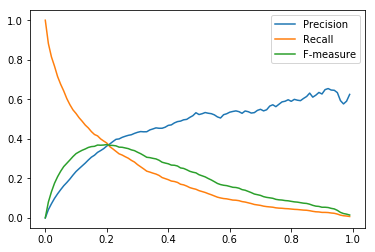

In [98]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print(precisions[0], fmeasures[0])
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
display(fig)

You can also create a similar plot using the Databricks `display()` function.

* Run the following cell.
* Then, select **Line** from the drop-down.
* Then, click on **Plot Options**, and configure the plot as shown below.

<img src="http://spark-mooc.github.io/web-assets/images/cs110x/lab3-change-plot-5c.png" alt="plot options" style="height: 500px"/>

In [100]:
# Create a DataFrame and visualize using display()
graph = [(t, precision(t), recall(t),fmeasure(t)) for t in thresholds]
graphRDD = sc.parallelize(graph)

graphRow = graphRDD.map(lambda kv: Row(threshold=kv[0], precision=kv[1], recall=kv[2], fmeasure=kv[3]))
graphDF = sqlContext.createDataFrame(graphRow)
display(graphDF)

fmeasure,precision,recall,threshold
0.0010645266950540452,5.325468026709271E-4,1.0,0.0
0.08061002178649238,0.04223433242506812,0.8823076923076923,0.01
0.1325489705238125,0.0721438790108318,0.8146153846153846,0.02
0.17584353801427186,0.09929360262660432,0.7676923076923077,0.03
0.2089183421318657,0.12232013678810996,0.7153846153846154,0.04
0.23648103309120258,0.14329964134333226,0.6761538461538461,0.05
0.2601651347561926,0.1631177964446181,0.6423076923076924,0.06
0.2767495152476644,0.17951063343242626,0.6038461538461538,0.07
0.2934226073257188,0.19719428268925357,0.573076923076923,0.08
0.3106838540528731,0.21696673787000306,0.546923076923077,0.09


## Discussion

State-of-the-art tools can get an F-measure of about 60% on this dataset. In this lab exercise, our best F-measure is closer to 40%. Look at some examples of errors (both False Positives and False Negatives) and think about what went wrong. (You don't have to submit an answer to this discussion question for the assignment, but it is a useful exercise.)

### There are several ways we might improve our simple classifier, including:
* Using additional attributes
* Performing better featurization of our textual data (e.g., stemming, n-grams, etc.)
* Using different similarity functions

## Export the notebook as an IPython notebook, then submit it to Gradescope!